In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorly.decomposition import parafac2
import tensorly as tl
from tensorly.parafac2_tensor import parafac2_to_slice
from tensorly.metrics.regression import variance as tl_var
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tfac.figures.figureCommon import subplotLabel, getSetup
from sklearn.metrics import roc_curve, roc_auc_score


tl.set_backend("numpy")

def R2Xparafac2(tensor_slices, decomposition):
    """Calculate the R2X of parafac2 decomposition"""
    R2X = [0, 0]
    for idx, tensor_slice in enumerate(tensor_slices):
        reconstruction = parafac2_to_slice(decomposition, idx, validate=False)
        R2X[idx] = 1.0 - tl_var(reconstruction - tensor_slice) / tl_var(tensor_slice)
    return R2X


In [2]:
def get_patient_info():
    """Return specific patiend ID information"""
    dataCohort = pd.read_csv("tfac/data/mrsa/clinical_metadata_cohort1.txt", delimiter='\t')
    cohortID = list(dataCohort["sample"])
    statusID = list(dataCohort["outcome_txt"])

    return cohortID, statusID

def form_MRSA_tensor(variance=29):
    """Create list of data matrices for parafac2"""
    dfClin, dfCoh = importClinicalMRSA()
    dfCyto = clinicalCyto(dfClin, dfCoh)
    dfCyto = dfCyto.sort_values(by='sid')
    dfCyto = dfCyto.set_index('sid')
    cytokines = dfCyto.columns

    dfExp = importExpressionData()
    dfExp = dfExp.T
    geneIDs = dfExp.iloc[0, 0:].to_list()
    dfExp.columns = geneIDs
    dfExp = dfExp.drop('Geneid')

    cytoNumpy = dfCyto.to_numpy().T
    expNumpy = dfExp.to_numpy().T

    expNumpy = expNumpy.astype(float)
    var = (tl_var(expNumpy)/tl_var(cytoNumpy))
    cytoNumpy = cytoNumpy * variance
    

    tensor_slices = [cytoNumpy, expNumpy]

    return tensor_slices, cytokines, geneIDs

def importClinicalMRSA():
    """import clincal MRSA data"""
    dataClin = pd.read_csv("tfac/data/mrsa/mrsa_s1s2_clin+cyto_073018.csv")
    dataCohort = pd.read_csv("tfac/data/mrsa/clinical_metadata_cohort1.txt", delimiter='\t')
    return dataClin, dataCohort

def clinicalCyto(dataClinical, dataCohort):
    """isolate cytokine data from clinical"""
    rowSize, colSize = dataClinical.shape
    patientID = list(dataClinical["sid"])

    dataClinical = dataClinical.drop(dataClinical.iloc[:, 0:3], axis=1)
    dataClinical = dataClinical.drop(dataClinical.iloc[:, 1:206], axis=1)

    """isolate patient IDs from cohort 1"""
    dataCohort = dataCohort.drop(columns=['age', 'gender', 'race', 'sampletype', 'pair', 'outcome_txt'], axis=1)
    cohortID = list(dataCohort["sample"])
    IDSize, column = dataCohort.shape

    cytokineData = pd.DataFrame()

    for y in range(0, rowSize):
        for z in range(0, IDSize):
            if (cohortID[z]).find(str(patientID[y])) != -1:
                temp = dataClinical.loc[dataClinical['sid'] == patientID[y]]
                cytokineData = pd.concat([temp, cytokineData])
    cytokineData.sort_values(by=['sid'])
    return cytokineData

def importExpressionData():
    """import expression data"""
    df = pd.read_table("tfac/data/mrsa/expression_counts_cohort1.txt")
    df.drop(["Chr", "Start", "End", "Strand", "Length"], inplace=True, axis=1)
    return df

0.4918032786885246
0.26229508196721313


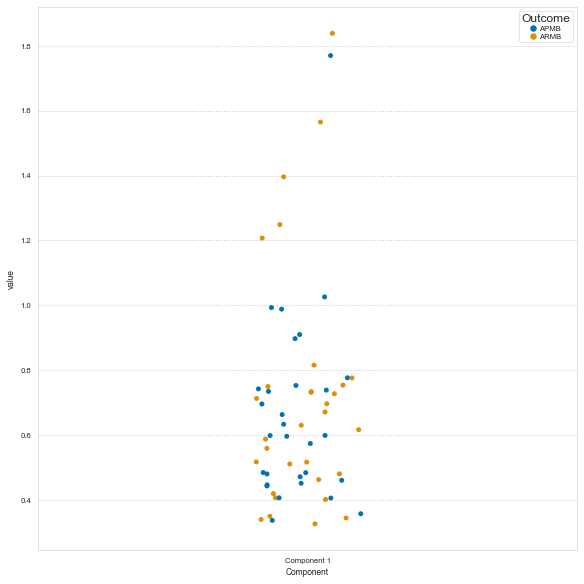

In [24]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(.5)
components = 1
parafac2tensor = parafac2(tensor_slices, components)
cohortID, outcomeID = get_patient_info()

patient_matrix = parafac2tensor[1][2]


outcome_bools = []

for outcome in outcomeID:
    if outcome == 'APMB':
        outcome_bools.append(0)
    else:
        outcome_bools.append(1)

outcomes = np.asarray(outcome_bools)


clf = LogisticRegression(random_state=1).fit(patient_matrix, outcomes)
c = clf.score(patient_matrix, outcomes)
print(c)


'''true_y = outcomes
score_y = clf.decision_function(patient_matrix)
fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])'''


kf = KFold(n_splits=61)
c = []
for train, test in kf.split(patient_matrix):
    clf = LogisticRegression(random_state=1).fit(patient_matrix[train], outcomes[train])
    c.append(clf.score(patient_matrix[test], outcomes[test]))
print(sum(c) / len(c))





patient_df = pd.DataFrame(patient_matrix)
patient_df['Outcome'] = outcomeID
columns = []
for component in range(1, components + 1):
    columns.append('Component ' + str(component))
columns.append('Outcome')
patient_df.columns = columns

patient_df = pd.melt(patient_df, id_vars=['Outcome'], var_name='Component')



ax, f = getSetup((8, 8), (1, 1))
sns.stripplot(data=patient_df, x='Component', y='value', hue='Outcome')

#plt.savefig('Components', dpi = 1200)

In [25]:
print(tl_var(tensor_slices[1])/tl_var(tensor_slices[0]))

11.07877770443756


In [17]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
components = 3
for i in range(1, 11):
    parafac2tensor, errors = parafac2(tensor_slices, i, return_errors=True)
    print(errors[-1])

0.478246571725162
0.3373442992034047
0.29489231565623575
0.24959675862301647
0.22277498355295916
0.1955687983300242
0.17158651845875794
0.15648551627575097
0.14521969348124456
0.13551705026720198


In [60]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
components = 10

AllR2X = []
BadR2X = []
for i in range(1, components + 1):
    best_error = np.inf
    parafac2tensor = None
    for run in range(2):
        decomposition, errors = parafac2(tensor_slices, i, return_errors=True)
        if best_error > errors[-1]:
            best_error = errors[-1]
            parafac2tensor = decomposition
    AllR2X.append(R2Xparafac2(tensor_slices, parafac2tensor))
df = pd.DataFrame(AllR2X)

comps = []
for i in range(1, components + 1):
    comps.append(i)
df['Component'] = comps

(0, 1)

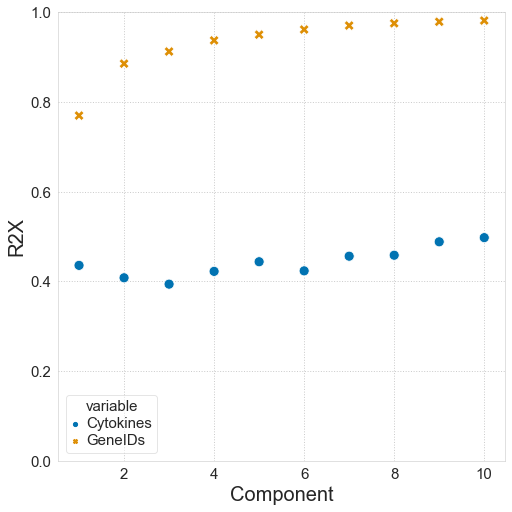

In [61]:
df.columns = ['Cytokines', 'GeneIDs', 'Component']
test = pd.melt(df, id_vars=['Component'])
ax, f = getSetup((7, 7), (1, 1))
b = sns.scatterplot(data=test, x='Component', y='value', hue='variable', style='variable', ax=ax[0], s=100)
b.set_xlabel("Component",fontsize=20)
b.set_ylabel("R2X",fontsize=20)
b.tick_params(labelsize=15)
plt.legend(prop={'size': 15})
ax[0].set_ylim(0, 1)
#plt.savefig('R2X_equal', dpi = 300)

Plot roc at var 1 and comp 31 and maybe var 29 and comp 31
Plot AUC vs var at comp 31
Plot AUC vs comp # at var 1

In [ ]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
components = 30
best_err = np.inf
parafac2tensor = None
for run in range(5):
    decomp, errs = parafac2(tensor_slices, components, return_errors=True)
    if best_err > errs[-1]:
        best_err = errs[-1]
        parafac2tensor = decomp

In [ ]:
patient_matrix = parafac2tensor[1][2]
for C in [.0001, .001, .01, .05, .1, .2, .5, 1, 2, 5, 10, 20, 30, 50]:
    kf = KFold(n_splits=61)
    decisions = []
    for train, test in kf.split(patient_matrix):
        clf = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=C).fit(patient_matrix[train], outcomes[train])
        decisions.append(clf.decision_function(patient_matrix[test]))
    true_y = outcomes
    score_y = decisions

    fpr, tpr, thresholds = roc_curve(true_y, score_y)
    auc = roc_auc_score(true_y, score_y)
    print(auc, C)
    '''df = pd.DataFrame()
    df['FPR'] = fpr
    df['TPR'] = tpr
    ax, f = getSetup((8, 8), (1, 1))
    sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
    df = pd.DataFrame()
    df['FPR'] = [0, 1]
    df['TPR'] = [0, 1]
    sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
    plt.savefig('ROC_curve_var1comp31', dpi = 300)'''

In [ ]:
0.24731182795698922 0.0001
0.35806451612903223 0.001
0.4731182795698925 0.01
0.37096774193548393 0.05
0.1494623655913978 0.1
0.2913978494623656 0.2
0.535483870967742 0.5
0.5397849462365591 1
0.6505376344086022 2
0.6924731182795699 5
0.7193548387096774 10
0.7150537634408602 20
0.7150537634408602 30
0.7053763440860215 50

0.7634408602150538


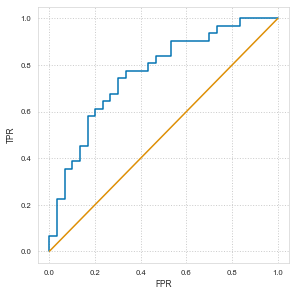

In [57]:
fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((4, 4), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
plt.savefig('ROC_curve_var1comp38', dpi = 600)

0.5731182795698925
0.5666666666666667


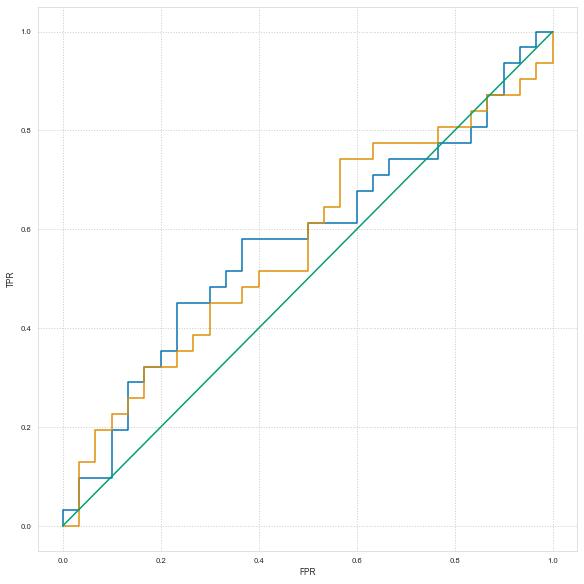

In [42]:
best_error = np.inf
parafac2tensor = None
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
components = 15
for run in range(5):
    decomposition, errors = parafac2(tensor_slices, components, return_errors=True)
    if best_error > errors[-1]:
        best_error = errors[-1]
        parafac2tensor = decomposition
        
        
patient_matrix = parafac2tensor[1][2]
kf = KFold(n_splits=61)
decisions = []
for train, test in kf.split(patient_matrix):
    clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
    decisions.append(clf.decision_function(patient_matrix[test]))
true_y = outcomes
score_y = decisions

fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])

df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
#plt.savefig('ROC_curve_var29comp31', dpi = 1200)

In [32]:
values_vars = []
for variance in [.001, .1, .5, 1, 2.25, 5, 29, 100, 1000]:
    tensor_slices, cytokines, geneIDs = form_MRSA_tensor(variance)
    components = 38
    parafac2tensor = parafac2(tensor_slices, components)

    patient_matrix = parafac2tensor[1][2]


    kf = KFold(n_splits=61)
    decisions = []
    for train, test in kf.split(patient_matrix):
        clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
        decisions.append(clf.decision_function(patient_matrix[test]))
    score_y = decisions
    auc = roc_auc_score(true_y, score_y)
    values_vars.append([variance, auc])
df_var = pd.DataFrame(values_vars)

In [43]:
values_comps = []
for components in range(1, 39):
    tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
    parafac2tensor = None
    best_error = np.inf
    for run in range(2):
        decomposition, errors = parafac2(tensor_slices, components, return_errors=True)
        if best_error > errors[-1]:
            best_error = errors[-1]
            parafac2tensor = decomposition

    patient_matrix = parafac2tensor[1][2]


    kf = KFold(n_splits=61)
    decisions = []
    for train, test in kf.split(patient_matrix):
        clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
        decisions.append(clf.decision_function(patient_matrix[test]))
    score_y = decisions
    auc = roc_auc_score(true_y, score_y)
    values_comps.append([components, auc])
df_comp = pd.DataFrame(values_comps)

ValueError: All the projection matrices of a PARAFAC2 tensor should have the same number of columns as the rank. However, rank=39 but projections[0].shape[1]=38

(0, 1)

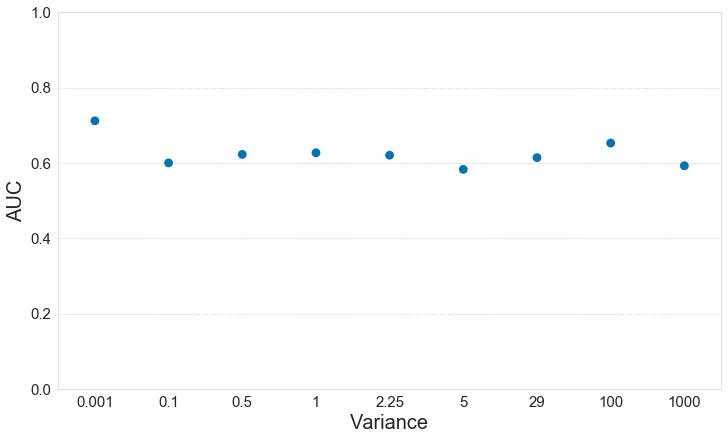

In [33]:
df_var.columns = ['Variance', 'AUC']
ax, f = getSetup((10, 6), (1, 1))

b = sns.pointplot(data=df_var, x='Variance', y='AUC', join=False, ax=ax[0])
b.set_xlabel("Variance",fontsize=20)
b.set_ylabel("AUC",fontsize=20)
b.tick_params(labelsize=15)
b.set_xticklabels([.001, .1, .5, 1, 2.25, 5, 29, 100, 1000])
ax[0].set_ylim(0, 1)
#plt.savefig('AUC_30comps_variance', dpi = 300)


In [ ]:
df_comp.columns = ['Components', 'AUC']
ax, f = getSetup((10, 5), (1, 1))
b = sns.scatterplot(data=df_comp, x='Components', y='AUC', ax=ax[0])
b.set_xlabel("Components",fontsize=20)
b.set_ylabel("AUC",fontsize=20)
b.tick_params(labelsize=14)
ax[0].set_ylim(0, 1)
plt.savefig('AUC_var1_comps', dpi = 300)

,sid,egf,eotaxin,tgfa,gcsf,fractalkine,ifng,gro,il10,il12p40,...,mcp3,il12p70,il1a,il9,il1b,il2,il3,il4,il7,tnfb
0,3429,62.820000,162.050003,13.91,6.110000,38.970001,3.630000,753.979981,2.550000,0.30,...,4.04,71.620003,2.310000,0.02,0.09,0.25,0.29,7.450000,3.97,2.68
1,3436,34.919998,14.360000,4.42,86.839996,31.549999,3.020000,624.659973,56.080002,0.30,...,2.98,2.140000,2.290000,0.02,0.03,0.02,0.29,3.220000,3.97,2.68
2,3443,51.000000,248.940002,3.30,1.940000,16.160000,2.790000,3078.000000,2.170000,0.30,...,2.98,2.140000,2.290000,0.02,0.03,0.02,0.29,10.670000,3.97,2.68
3,3453,218.740006,139.960007,6.22,48.290001,1288.000000,10.300000,1675.000000,2.170000,0.30,...,6.95,2.750000,9.130000,0.02,0.73,0.02,0.29,327.209992,3.97,2.68
4,3456,403.019989,60.740002,7.10,0.800000,16.160000,29.940001,1826.000000,2.170000,0.30,...,2.98,34.279999,12.560000,0.02,0.03,0.02,0.29,3.220000,3.97,2.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,5572,63.560001,206.070007,4.12,1.940000,56.669998,6.410000,1851.000000,2.170000,0.30,...,24.26,4.820000,50.919998,0.02,2.35,0.59,0.29,322.910004,3.97,2.68
144,5682,327.760010,72.760002,13.05,3.200000,97.919998,0.770000,10188.000000,12.620000,2.43,...,14.57,2.140000,9.130000,7.46,1.05,0.02,0.29,484.700000,3.97,2.68
145,5687,3.000000,94.720001,3.30,4.600000,16.160000,2.790000,4080.000000,4.700000,7.43,...,9.44,2.140000,2.290000,0.02,0.03,0.02,0.29,47.560001,3.97,2.68
146,5690,23.520000,50.310001,3.30,0.800000,91.959999,4.010000,1314.000000,8.370000,0.30,...,2.98,2.140000,30.830000,0.02,0.03,0.02,0.29,104.000000,3.97,2.68


In [ ]:
def proteinPlot(ax, factors, r1, r2):
    '''Plot proteins (tensor axis 2) in factorization component space'''
    sns.scatterplot(factors[:, r1 - 1], factors[:, r2 - 1], ax=ax)
    ax.set_xlabel('Component ' + str(r1))
    ax.set_ylabel('Component ' + str(r2))
    ax.set_title('Protein Factors')
    setPlotLimits(ax, factors, r1, r2)